## Document Search : Comorbidities Minor

In [38]:
import sys
import json
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from collections import Counter

#### Entity Preparation

In [39]:
with open("input/comorb-minor.json",'r')as fin:
    comorb = json.load(fin)

In [40]:
meshtree_file = "input/mtrees2021.bin"

In [41]:
DT = {"cerebrovascular disorders":[]}
with open(meshtree_file, "r") as ftree:
    for line in ftree:
        term_tree = line.strip().split(";")
        cur_term = term_tree[0]
        cur_tree = term_tree[1]
        
        if cur_tree[0:11] == "C14.907.253":
            #print(cur_term)
            DT["cerebrovascular disorders"].append(cur_term)

In [42]:
#DT['cerebrovascular disorders']

In [43]:
comorb.update({'cerebrovascular disorders': DT["cerebrovascular disorders"]})

In [44]:
#comorb

#### Entity search

In [48]:
with open('data/t2pmid-covid.json','r')as f2:
    t2pmid = json.load(f2)

In [49]:
tdf = pd.DataFrame(t2pmid)
tdf.head()

,pmid,mesh,date,title,abstract
0,32071063,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '18', ...",Coronavirus covid-19 has killed more people th...,
1,32072794,[],"{'Year': '2020', 'Month': '02', 'Day': '19', '...",[Cluster investigation Technical Guidelines fo...,
2,32086235,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '21', ...",Rules on isolation rooms for suspected covid-1...,
3,32087216,"['Betacoronavirus', 'genetics', 'pathogenicity...","{'Year': '2020', 'Month': '04', 'Day': '', 'Se...",A Novel Coronavirus (COVID-19) Outbreak: A Cal...,
4,32093043,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '19', ...",Risk Assessment of Novel Coronavirus COVID-19 ...,we developed a computational tool to assess th...


In [50]:
tdf.shape

(80732, 5)

In [51]:
covid_pmids = list(set(tdf['pmid']))
len(covid_pmids)

80732

#### Count Comorb Publications 

In [69]:
n2count = {}
n2pmid = {}
n2pmidset = {}
allpmids = []
for name in comorb:
    n2count[name] = 0
    n2pmid[name] = 0
    n2pmidset[name] = []
    
            
for pmid,title,abstract,mesh in  zip(tdf['pmid'],tdf['title'],tdf['abstract'],tdf['mesh']):
    
        
    for name, entities in comorb.items():
        tn = 0
        for entity in entities:
            
            n_title = title.count(entity)
            tn = tn+n_title
            
            if len(abstract)>1:
                text = abstract
                
            n_abs = text.count(entity)
            tn = tn+n_abs
            
            n_mesh = mesh.count(entity)
            tn = tn+n_mesh
            
        n2count[name] = n2count[name] + tn
        
        if tn>0:
            n2pmid[name] = n2pmid[name] + 1
            n2pmidset[name].append(pmid)
            allpmids.append(pmid)
                

In [70]:
with open('result/n2pmidset-comorb-minor.json','w')as f3:
    json.dump(n2pmidset,f3)

In [71]:
len(set(allpmids))

4851

#### Individual Comorb Document count

In [73]:
Data = []
for name, count in n2pmid.items():
    Data.append({"Name":name,"Text Datasets": count})
    
df = pd.DataFrame(Data)
df.to_csv("result/comorb-count-minor.csv")

#### Covid Symptoms and Comorb

In [75]:
with open('result/name2pmidset-covid.json','r')as f4:
    n2pmidset_covid = json.load(f4)

In [76]:
Data = []
allpmid = []
for name1, pmids1 in n2pmidset_covid.items():
    data = {}
    data.update({"covid symptoms" : name1})
                
    for name2, pmids2 in n2pmidset.items():
        ints = set(pmids1).intersection(set(pmids2))
        
        for item in list(ints):
            allpmid.append(item)
            
        data.update({name2:len(set(ints))})
    
    Data.append(data)
        

In [77]:
len(list(set(allpmid)))

816

In [78]:
cdf = pd.DataFrame(Data)
#cdf.to_csv("covid-comorb-minor.csv")

In [79]:
cdf = cdf.set_index("covid symptoms")

In [80]:
tcdf = cdf.T
tcdf = tcdf.sort_index()
tcdf

covid symptoms,fever,chills,cough,fatigue,shortness of breath,sore throat,rhinorrhea,diarrhea,vomiting,nausea,headache,myalgia,ageusia,confusion,chest pain,anosmia,cyanosis,hypersomnia
acquired immunodeficiency syndrome,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
asthma,51,2,59,18,44,12,5,10,12,6,11,15,9,2,11,13,1,0
bone marrow transplantation,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cerebrovascular disorders,35,4,29,10,14,0,0,2,3,2,35,15,10,8,0,16,0,0
cystic fibrosis,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dementia,8,1,8,10,7,1,1,0,0,2,4,1,1,10,0,3,0,0
hiv,48,16,46,24,25,2,5,11,12,11,15,16,9,2,7,9,0,0
hypertension,378,23,313,100,243,45,7,46,26,22,75,57,6,11,30,38,5,0
immunosuppressive agents,3,2,4,1,3,0,1,1,0,0,0,0,1,0,0,1,0,0
liver diseases,8,3,5,1,1,1,0,3,2,3,1,2,0,0,0,1,0,0


In [81]:
tcdf.to_csv("result/covid-comorb-minor.csv")

In [82]:
cdf.sum()

asthma                                 281
hypertension                          1425
thalassemia                              8
cerebrovascular disorders              183
liver diseases                          31
hiv                                    258
immunosuppressive agents                17
bone marrow transplantation              5
cystic fibrosis                          2
pulmonary fibrosis                      49
dementia                                57
acquired immunodeficiency syndrome       0
dtype: int64

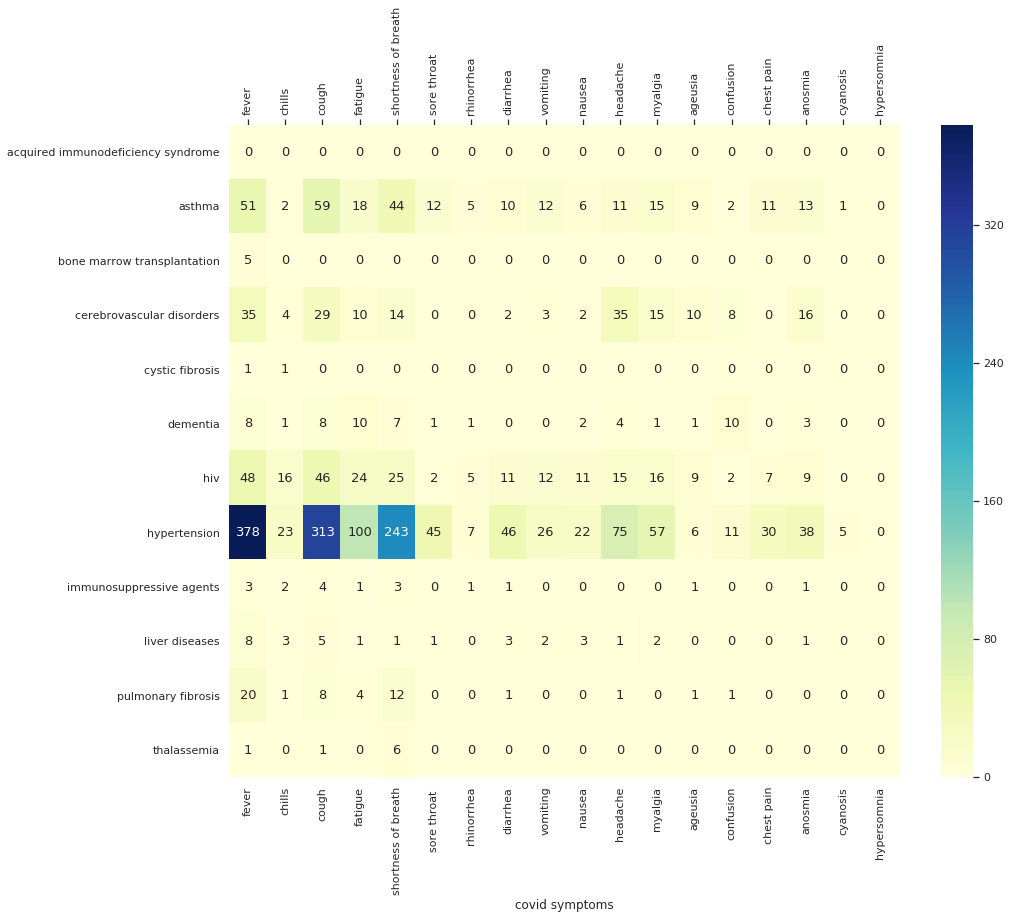

In [83]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

matplotlib.rcParams.update({'font.size': 13})
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

plt.figure(figsize = [15,12])

#idf = newdf.set_index("name")
sns.heatmap(tcdf, annot=True, cmap = "YlGnBu", fmt = "d")


plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

plt.savefig("plots/heatmap_comorb_minor.png")